# 2.0 Pose Dimension Calculator

The `PoseDimensionCalculator` class operates through a series of algorithmic steps to calculate dimensions and angles based on pose data. Here's a technical breakdown of its key functions and the formulas used:

1. `enhance_pose_landmarks()`:  This method refines the pose data by creating additional landmark points to represent key body parts more accurately. It approximates the spine's location using the average coordinates of the torso's four landmarks (head, chest, stomach, and hips) and simplifies hand landmarks by averaging the coordinates of the pinky and index fingers to estimate the central position of the knuckles.
2. `calculate_height_spine()`: This method calculates the sum of Euclidean distances between head to chest, chest to stomach, and stomach to hip.
3. `calculate_height_right_leg()` & `calculate_height_left_leg()`: These methods calculate the sum of Euclidean distances between hip to knee, knee to ankle, and ankle to toes.
4. `calculate_width_right_arm()` & `calculate_width_left_arm()`: These methods calculate the sum of Euclidean distances between shoulder to elbow, elbow to wrist, and elbow to knuckles.
5. `calculate_pose_angle()` & `calculate_connected_joint_range()`: These methods use `arctan2` to compute the angle between two vectors (connected joints based on human anatomy).

Concepts:
* Eucleandian Distance: https://science.howstuffworks.com/math-concepts/distance-formula.htm
* Atan2: https://en.wikipedia.org/wiki/Atan2

### Implementation

In [1]:
import numpy as np
import pandas as pd

class PoseDimensionCalculator:
    
    def __init__(self, data, is_video=False):
        self.data = data
        
        self.enhance_pose_landmarks = self.enhance_pose_landmarks()
        self.data = self.enhance_pose_landmarks

        self.hgt_spine = self.calculate_height_spine()
        self.data['hgt_spine'] = self.hgt_spine

        self.hgt_rgt_leg = self.calculate_height_right_leg()
        self.data['hgt_rgt_leg'] = self.hgt_rgt_leg

        self.hgt_lft_leg = self.calculate_height_left_leg()
        self.data['hgt_lft_leg'] = self.hgt_lft_leg

        self.wid_rgt_arm = self.calculate_width_right_arm()
        self.data['wid_rgt_arm'] = self.wid_rgt_arm

        self.wid_lft_arm = self.calculate_width_left_arm()
        self.data['wid_lft_arm'] = self.wid_lft_arm
        
        angles = self.calculate_connected_joint_range()
        self.data = pd.concat([self.data, angles], axis=1)

        if is_video:
            rate_of_change = self.calculate_rate_of_change()
            self.data = pd.concat([self.data, rate_of_change], axis=1)

    def enhance_pose_landmarks(self):
        enhanced_data = []
        for index, row in self.data.iterrows():
            enhanced_row = self.process_row(row)
            enhanced_row['index'] = index
            enhanced_data.append(enhanced_row)
        enhanced_df = pd.DataFrame(enhanced_data).set_index('index')  # Set the index of the DataFrame
        merged = pd.concat([self.data, enhanced_df], axis=1)  # Merge with the original DataFrame
        return merged

    def process_row(self, row):
        x_cols = sorted([col for col in self.data.columns if col.endswith('_x')])
        y_cols = sorted([col for col in self.data.columns if col.endswith('_y')])
        z_cols = sorted([col for col in self.data.columns if col.endswith('_z')])
        
        x = row[x_cols].values
        y = row[y_cols].values
        z = row[z_cols].values

        enhanced_row = {
            
            'head_x': x[0:10].mean(),
            'head_y': y[0:10].mean(),
            'head_z': z[0:10].mean(),
            'chest_x': x[11:13].mean(),
            'chest_y': y[11:13].mean(), 
            'chest_z': z[11:13].mean(),
            'stomach_x': (x[11:13].mean() + x[23:24].mean()) / 2,
            'stomach_y': (y[11:13].mean() + y[23:24].mean()) / 2,
            'stomach_z': (z[11:13].mean() + z[23:24].mean()) / 2,
            'hip_x': x[23:25].mean(),
            'hip_y': y[23:25].mean(),
            'hip_z': z[23:25].mean(),
            
            'knuckles_right_x': (x[18] + x[20])/2,
            'knuckles_right_y': (y[18] + y[20])/2,
            'knuckles_right_z': (z[18] + z[20])/2,
            'knuckles_left_x': (x[17] + x[19])/2,
            'knuckles_left_y': (y[17] + y[19])/2,
            'knuckles_left_z': (z[17] + z[19])/2,
        }

        return enhanced_row

    def calculate_height_spine(self):
        try:
            hgt_head_to_chest = np.sqrt((self.data['head_x'] - self.data['chest_x'])**2 + (self.data['head_y'] - self.data['chest_y'])**2)
            hgt_chest_to_hip = np.sqrt((self.data['chest_x'] - self.data['hip_x'])**2 + (self.data['chest_y'] - self.data['hip_y'])**2)
            hgt_spine = hgt_head_to_chest + hgt_chest_to_hip
        except ValueError as ve:
            print(f'Error: {ve}')
            hgt_spine = 0
        return pd.Series(hgt_spine, index=self.data.index)
    
    def calculate_height_right_leg(self):
        
        hgt_hip_to_knee = np.sqrt((self.data['hip_x'] - self.data['landmark_26_x'])**2 + (self.data['hip_y'] - self.data['landmark_26_y'])**2)
        hgt_knee_to_ankle = np.sqrt((self.data['landmark_26_x'] - self.data['landmark_28_x'])**2 + (self.data['landmark_26_y'] - self.data['landmark_28_y'])**2)
        hgt_ankle_to_toes = np.sqrt((self.data['landmark_28_x'] - self.data['landmark_32_x'])**2 + (self.data['landmark_28_y'] - self.data['landmark_32_y'])**2)
        hgt_rgt_leg = hgt_hip_to_knee + hgt_knee_to_ankle + hgt_ankle_to_toes
        
        return pd.Series(hgt_rgt_leg, index=self.data.index)

    def calculate_height_left_leg(self):
        hgt_hip_to_knee = np.sqrt((self.data['hip_x'] - self.data['landmark_25_x'])**2 + (self.data['hip_y'] - self.data['landmark_25_y'])**2)
        hgt_knee_to_ankle = np.sqrt((self.data['landmark_25_x'] - self.data['landmark_27_x'])**2 + (self.data['landmark_25_y'] - self.data['landmark_27_y'])**2)
        hgt_ankle_to_toes = np.sqrt((self.data['landmark_27_x'] - self.data['landmark_31_x'])**2 + (self.data['landmark_27_y'] - self.data['landmark_31_y'])**2)
        
        hgt_lft_leg  = hgt_hip_to_knee + hgt_knee_to_ankle + hgt_ankle_to_toes
        return pd.Series(hgt_lft_leg, index=self.data.index)

    def calculate_width_right_arm(self):
        
        wid_chest_to_shoulder = np.sqrt((self.data['chest_x'] - self.data['landmark_12_x'])**2 + (self.data['chest_y'] - self.data['landmark_12_y'])**2)
        wid_shoulder_to_elbow = np.sqrt((self.data['landmark_12_x'] - self.data['landmark_14_x'])**2 + (self.data['landmark_12_y'] - self.data['landmark_14_y'])**2)
        wid_elbow_to_wrist = np.sqrt((self.data['landmark_14_x'] - self.data['landmark_16_x'])**2 + (self.data['landmark_14_y'] - self.data['landmark_16_y'])**2)
        wid_elbow_to_knuckles = np.sqrt((self.data['landmark_16_x'] - self.data['knuckles_right_x'])**2 + (self.data['landmark_16_y'] - self.data['knuckles_right_y'])**2)
        
        wid_rgt_arm = wid_chest_to_shoulder + wid_shoulder_to_elbow + wid_elbow_to_wrist + wid_elbow_to_knuckles
        
        return pd.Series(wid_rgt_arm, index=self.data.index)

    def calculate_width_left_arm(self):
        
        wid_chest_to_shoulder = np.sqrt((self.data['chest_x'] - self.data['landmark_11_x'])**2 + (self.data['chest_y'] - self.data['landmark_11_y'])**2)
        wid_shoulder_to_elbow = np.sqrt((self.data['landmark_11_x'] - self.data['landmark_13_x'])**2 + (self.data['landmark_11_y'] - self.data['landmark_13_y'])**2)
        wid_elbow_to_wrist = np.sqrt((self.data['landmark_13_x'] - self.data['landmark_15_x'])**2 + (self.data['landmark_13_y'] - self.data['landmark_15_y'])**2)
        wid_elbow_to_knuckles = np.sqrt((self.data['landmark_15_x'] - self.data['knuckles_left_x'])**2 + (self.data['landmark_15_y'] - self.data['knuckles_left_y'])**2)
        
        wid_lft_arm = wid_chest_to_shoulder + wid_shoulder_to_elbow + wid_elbow_to_wrist + wid_elbow_to_knuckles
        
        return pd.Series(wid_lft_arm, index=self.data.index)

    def calculate_pose_angle(self, Ax, Ay, Bx, By, Cx, Cy):
        A = self.data[[Ax, Ay]].values
        B = self.data[[Bx, By]].values
        C = self.data[[Cx, Cy]].values
        BA = A - B
        BC = C - B
        angle_BA = np.arctan2(BA[:, 1], BA[:, 0])
        angle_BC = np.arctan2(BC[:, 1], BC[:, 0])
        angle_difference = np.degrees(angle_BC - angle_BA)    
        return np.round(angle_difference, 4)
        
    def calculate_connected_joint_range(self):
        
        angles = pd.DataFrame(index=self.data.index)
        
        angles['a_head_to_stomach'] = self.calculate_pose_angle('head_x', 'head_y', 'chest_x', 'chest_y','stomach_x','stomach_y')
        angles['a_chest_to_hip'] = self.calculate_pose_angle('chest_x', 'chest_y', 'stomach_x', 'stomach_y','hip_x','hip_y')
        angles['a_mid_hip_to_knees'] = self.calculate_pose_angle('landmark_26_x','landmark_26_y','hip_x', 'hip_y','landmark_25_x','landmark_25_y')
        angles['a_rgt_shoulder_to_wrist'] = self.calculate_pose_angle('landmark_12_x', 'landmark_12_y', 'landmark_14_x', 'landmark_14_y', 'landmark_16_x', 'landmark_16_y')
        angles['a_rgt_elbow_to_knuckles'] = self.calculate_pose_angle('landmark_14_x', 'landmark_14_y', 'landmark_16_x', 'landmark_16_y', 'knuckles_right_x', 'knuckles_right_y')               
        angles['a_rgt_thumb_to_knuckles'] = self.calculate_pose_angle('landmark_22_x', 'landmark_22_y', 'landmark_18_x', 'landmark_18_y', 'knuckles_right_x', 'knuckles_right_y')       
        angles['a_rgt_shoulder_to_knee'] = self.calculate_pose_angle('landmark_12_x', 'landmark_12_y', 'landmark_24_x', 'landmark_24_y','landmark_26_x', 'landmark_26_y')
        angles['a_rgt_hip_to_foot'] = self.calculate_pose_angle('landmark_24_x', 'landmark_24_y', 'landmark_26_x', 'landmark_26_y','landmark_28_x', 'landmark_28_y')
        angles['a_rgt_foot_to_ankle'] = self.calculate_pose_angle('landmark_26_x', 'landmark_26_y', 'landmark_28_x', 'landmark_28_y','landmark_32_x', 'landmark_32_y')
        angles['a_lft_shoulder_to_wrist'] = self.calculate_pose_angle('landmark_11_x', 'landmark_11_y', 'landmark_13_x', 'landmark_13_y', 'landmark_15_x', 'landmark_15_y')
        angles['a_lft_elbow_to_knuckles'] = self.calculate_pose_angle('landmark_13_x', 'landmark_13_y', 'landmark_15_x', 'landmark_15_y', 'knuckles_left_x', 'knuckles_left_y')               
        angles['a_lft_thumb_to_knuckles'] = self.calculate_pose_angle('landmark_21_x', 'landmark_21_y', 'landmark_17_x', 'landmark_17_y', 'knuckles_left_x', 'knuckles_left_y')       
        angles['a_lft_shoulder_to_knee'] = self.calculate_pose_angle('landmark_11_x', 'landmark_11_y', 'landmark_23_x', 'landmark_23_y','landmark_25_x', 'landmark_25_y')
        angles['a_lft_hip_to_foot'] = self.calculate_pose_angle('landmark_23_x', 'landmark_23_y', 'landmark_25_x', 'landmark_25_y','landmark_27_x', 'landmark_27_y')
        angles['a_lft_foot_to_ankle'] = self.calculate_pose_angle('landmark_25_x', 'landmark_25_y', 'landmark_27_x', 'landmark_27_y','landmark_31_x', 'landmark_31_y')
        
        return angles
        
    def calculate_rate_of_change(self):
        heights = ['hgt_spine', 'wid_rgt_arm', 'wid_lft_arm', 'hgt_rgt_leg', 'hgt_lft_leg']
        grouped_data = self.data.groupby('secs')[heights].mean()

        for col in heights:
            differences = grouped_data[col].diff().fillna(0)
            roc = differences
            grouped_data[f'roc_{col}'] = roc
        selected_columns = self.data[['secs', 'frame_no', 'image_filename']].drop_duplicates()
        merged_data = pd.merge(selected_columns, grouped_data[[f'roc_{col}' for col in heights]], 
                               left_on='secs', right_index=True, how='left')

        self.data = merged_data
        return self
        
    def save_transformed_data(self, filename):
        self.data.to_csv(filename, index=False)

# Example Usage

In [ ]:
gt_upright_path = 'data/ground_truth/processed/upright/pose_data.csv'
gt_upright = pd.read_csv(gt_upright_path)
pd_upright = PoseDimensionCalculator(gt_upright)
pd_upright.data.to_csv(gt_upright_path, index=False)

pd_upright.data.head(5)

## 2.1 Pose Dimension Visualization

Heights and angles are visualized for quick inspection.

In [ ]:
data = pd.read_csv('data/internal/tricks/pose_data_raw.csv')
data.head(5)

In [ ]:
pose_dimension_calculator = PoseDimensionCalculator(data)
pose_dimension_calculator.save_transformed_data('data/internal/tricks/pose_data.csv')

In [2]:
from helpers.data_visualization_utils import *

def visualize_pose_dimension_by_sec(source_image_dir, input_data, sec):
    data['secs'] = data['secs'].astype(int)
    filtered_data = data[data['secs'] == sec]
    
    row = filtered_data.iloc[0]

    focus_angles = {
        'Head->Stomach': (row['a_head_to_stomach'], row['head_x'], row['head_y'],row['chest_x'], row['chest_y'], row['stomach_x'], row['stomach_y']),
        'R.Shoulder->Wrist': (row['a_rgt_shoulder_to_wrist'], row['landmark_12_x'], row['landmark_12_y'],row['landmark_14_x'], row['landmark_14_y'], row['landmark_16_x'],row['landmark_16_y']),
        'R.Elbow->Knuckles': (row['a_rgt_elbow_to_knuckles'], row['landmark_14_x'],row['landmark_14_y'], row['landmark_16_x'], row['landmark_16_y'], row['knuckles_right_x'],row['knuckles_right_y']),
        'R.Foot->Ankle': (row['a_rgt_hip_to_foot'], row['landmark_24_x'], row['landmark_24_y'],row['landmark_26_x'], row['landmark_26_y'], row['landmark_28_x'],row['landmark_28_y']),
        'L.Shoulder->Wrist': (row['a_lft_shoulder_to_wrist'], row['landmark_11_x'], row['landmark_11_y'],row['landmark_13_x'], row['landmark_13_y'], row['landmark_15_x'],row['landmark_15_y']),
        'L.Elbow->Knuckles': (row['a_lft_elbow_to_knuckles'], row['landmark_13_x'],row['landmark_13_y'], row['landmark_15_x'], row['landmark_15_y'], row['knuckles_left_x'],row['knuckles_left_y']),
        'L.Foot->Ankle': (row['a_lft_hip_to_foot'], row['landmark_23_x'], row['landmark_23_y'],row['landmark_25_x'], row['landmark_26_y'], row['landmark_27_x'],row['landmark_27_y']),
    }

    focus_heights = {
        'Spine': (row['hgt_spine'], row['head_x'],row['head_y'],row['hip_x'],row['hip_y']),
        'R.Leg': (row['hgt_rgt_leg'], row['landmark_24_x'],row['landmark_24_y'],row['landmark_32_x'],row['landmark_32_y']),
        'L.Leg': (row['hgt_lft_leg'], row['landmark_23_x'],row['landmark_23_y'],row['landmark_31_x'],row['landmark_31_y']),
        'R.Arm': (row['wid_rgt_arm'], row['landmark_12_x'],row['landmark_12_y'],row['knuckles_right_x'],row['knuckles_right_y']),
        'L.Arm': (row['wid_lft_arm'], row['landmark_11_x'],row['landmark_11_y'],row['knuckles_left_x'],row['knuckles_left_y']),
    }   
    
    visualize_pose_dimension_lengths(source_image_dir, row, focus_heights)
    visualize_pose_dimension_angles(source_image_dir, row, focus_angles)

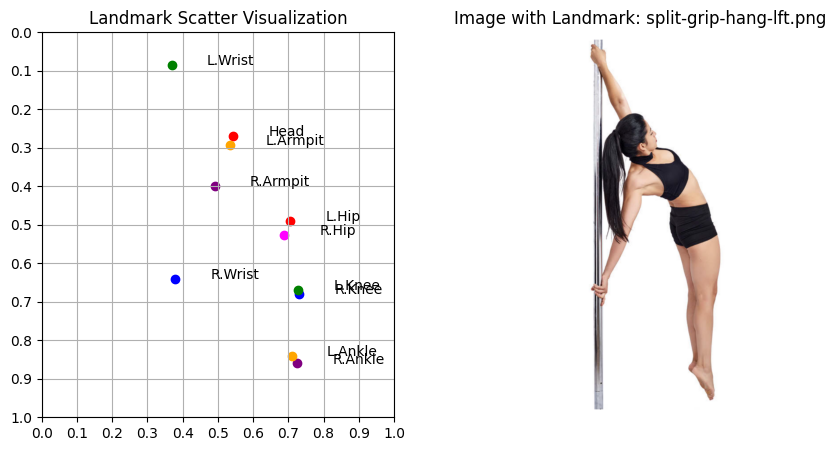

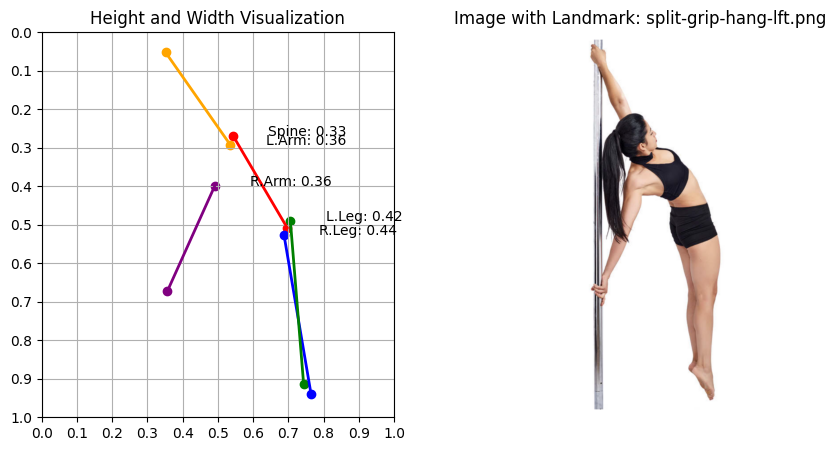

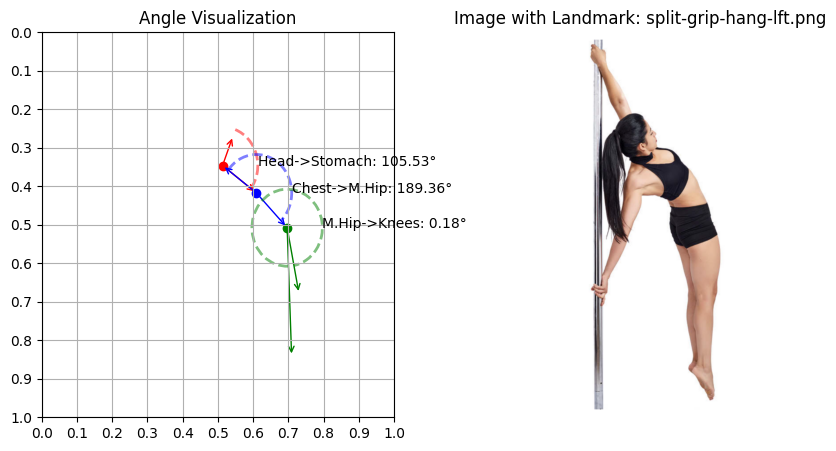

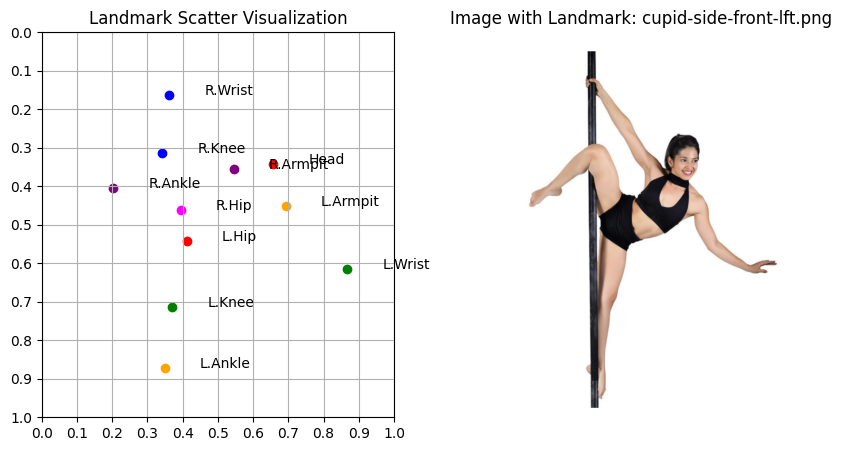

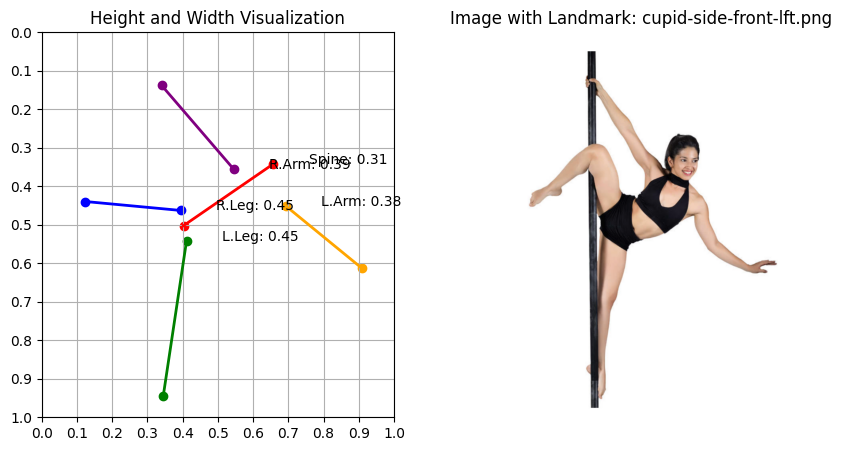

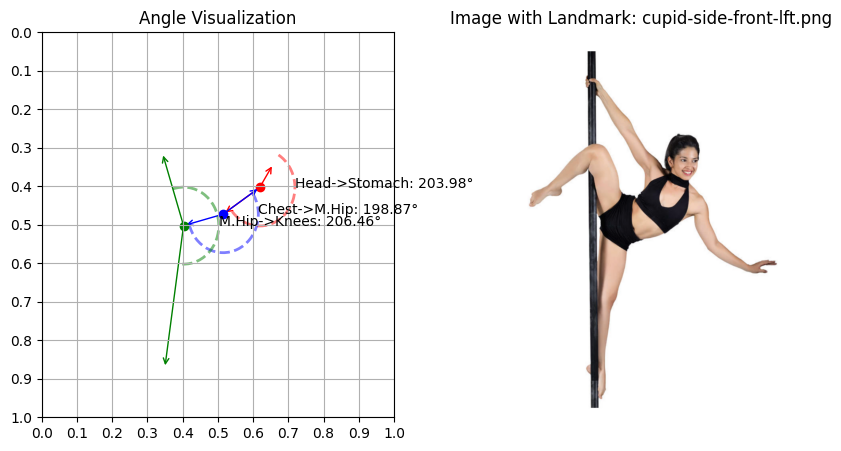

In [12]:
def visualize_pose_dimension_by_keyword(source_image_dir, input_data, keyword):
    filtered_data = data[data['pose_name'].str.startswith(keyword)]

    row = filtered_data.iloc[0]

    focus_landmarks = {
        'Head': (row['head_x'], row['head_y']),
        'R.Wrist': (row['landmark_16_x'], row['landmark_16_y']),
        'L.Wrist': (row['landmark_15_x'], row['landmark_15_y']),
        'R.Armpit': (row['landmark_12_x'], row['landmark_12_y']),
        'L.Armpit': (row['landmark_11_x'], row['landmark_11_y']),
        'R.Hip': (row['landmark_24_x'], row['landmark_24_y']),
        'L.Hip': (row['landmark_23_x'], row['landmark_23_y']),
        'R.Knee': (row['landmark_26_x'], row['landmark_26_y']),
        'L.Knee': (row['landmark_25_x'], row['landmark_25_y']),
        'R.Ankle': (row['landmark_28_x'], row['landmark_28_y']),
        'L.Ankle': (row['landmark_27_x'], row['landmark_27_y']),
    }
    
    focus_angles = {
        'Head->Stomach': (row['a_head_to_stomach'], row['head_x'], row['head_y'],row['chest_x'], row['chest_y'], row['stomach_x'], row['stomach_y']),
        'Chest->M.Hip': (row['a_chest_to_hip'], row['chest_x'], row['chest_y'],row['stomach_x'], row['stomach_y'], row['hip_x'], row['hip_y']),
        'M.Hip->Knees': (row['a_mid_hip_to_knees'], row['landmark_26_x'], row['landmark_26_y'],row['hip_x'], row['hip_y'], row['landmark_27_x'], row['landmark_27_y']),

    }

    focus_heights = {
        'Spine': (row['hgt_spine'], row['head_x'],row['head_y'],row['hip_x'],row['hip_y']),
        'R.Leg': (row['hgt_rgt_leg'], row['landmark_24_x'],row['landmark_24_y'],row['landmark_32_x'],row['landmark_32_y']),
        'L.Leg': (row['hgt_lft_leg'], row['landmark_23_x'],row['landmark_23_y'],row['landmark_31_x'],row['landmark_31_y']),
        'R.Arm': (row['wid_rgt_arm'], row['landmark_12_x'],row['landmark_12_y'],row['knuckles_right_x'],row['knuckles_right_y']),
        'L.Arm': (row['wid_lft_arm'], row['landmark_11_x'],row['landmark_11_y'],row['knuckles_left_x'],row['knuckles_left_y']),
    }   
    
    visualize_pose_coordinates(source_image_dir, row, focus_landmarks)
    visualize_pose_dimension_lengths(source_image_dir, row, focus_heights)
    visualize_pose_dimension_angles(source_image_dir, row, focus_angles)

data = pd.read_csv('data/internal/tricks/pose_data.csv')
source_image_dir = 'data/internal/tricks/'

visualize_pose_dimension_by_keyword(source_image_dir, data, 'split-grip-hang-lft')
visualize_pose_dimension_by_keyword(source_image_dir, data, 'cupid-side-front-lft')